In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd

import dython

In [86]:
relative_dir = "../data/curated/"
income = pd.read_csv("../data/raw/external/vic_income.csv", index_col=0)
mapping = pd.read_csv("../data/raw/external/sa2_postcode_map.csv", index_col=0)
properties = pd.read_csv(relative_dir + "categorised_distances.csv", index_col=0)

In [87]:
properties['Postcode'] = properties['Postcode'].astype(str)

In [88]:
mapping['POSTCODE'] = mapping['POSTCODE'].astype(str)

In [89]:
properties = pd.merge(properties, mapping, left_on='Postcode', right_on='POSTCODE').drop('POSTCODE', axis=1)

In [90]:
properties['SA2_MAINCODE_2011'] = properties['SA2_MAINCODE_2011'].astype(str)
properties = properties.rename({'SA2_MAINCODE_2011':'SA2'})

In [91]:
properties.head()

,Name,Cost,Coordinates,Bed,Bath,Parking,Property_Type,Agency,Postcode,cbd_duration,...,postoffice_duration,primary_duration,secondary_duration,station_distance,park_distance,postoffice_distance,primary_distance,secondary_distance,SA2_MAINCODE_2011,SA2_NAME_2011
0,5408/500 Elizabeth Street Melbourne VIC 3000,440.0,"[-37.8072443, 144.9602814]",1,1,0,Apartment / Unit / Flat,BRADY residential,3000,80.0,...,1,1,1,1,1,1,1,1,206041122.0,Melbourne
1,502/118 Russell Street Melbourne VIC 3000,620.0,"[-37.8135864, 144.9687232]",1,1,0,Apartment / Unit / Flat,Dingle Partners,3000,113.5,...,1,1,1,1,1,1,1,1,206041122.0,Melbourne
2,202A/441 Lonsdale Street Melbourne VIC 3000,300.0,"[-37.8134292, 144.9594445]",1,1,0,Apartment / Unit / Flat,Biggin & Scott Stonnington,3000,70.4,...,1,1,1,1,1,1,1,1,206041122.0,Melbourne
3,57/243 Collins Street Melbourne VIC 3000,400.0,"[-37.8159969, 144.9657956]",1,1,0,Apartment / Unit / Flat,Harcourts Melbourne City,3000,93.4,...,1,2,1,1,1,1,1,1,206041122.0,Melbourne
4,2311/601 Little Lonsdale Street Melbourne VIC ...,625.0,"[-37.8137564, 144.9537143]",2,2,1,Apartment / Unit / Flat,Harcourts Melbourne City,3000,136.8,...,1,2,1,1,1,1,1,1,206041122.0,Melbourne


## Income Data

In [92]:
income['SA2'] = income['SA2'].astype(str)
income.head()

,SA2,SA2_name,Earners,Median_age,Sum,Median
579,201011001,Alfredton,7989,42,508645842,53932
580,201011002,Ballarat,7595,47,591465895,53688
581,201011003,Ballarat - North,13598,43,820866354,50593
582,201011004,Ballarat - South,12722,40,646001740,45828
583,201011005,Buninyong,4249,46,268782250,52377


In [93]:
properties['SA2_MAINCODE_2011'] = properties['SA2_MAINCODE_2011'].astype(float).astype(int).astype(str)
properties = pd.merge(properties, income, left_on='SA2_MAINCODE_2011', right_on='SA2')
properties.head(1)

,Name,Cost,Coordinates,Bed,Bath,Parking,Property_Type,Agency,Postcode,cbd_duration,...,primary_distance,secondary_distance,SA2_MAINCODE_2011,SA2_NAME_2011,SA2,SA2_name,Earners,Median_age,Sum,Median
0,5408/500 Elizabeth Street Melbourne VIC 3000,440.0,"[-37.8072443, 144.9602814]",1,1,0,Apartment / Unit / Flat,BRADY residential,3000,80.0,...,1,1,206041122,Melbourne,206041122,Melbourne,27182,30,1426389488,30024


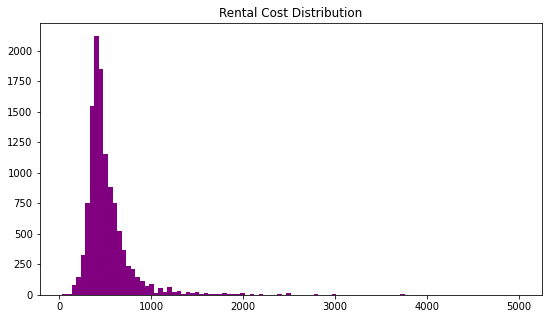

In [94]:
# Rental Cost Distribution
plt.figure(figsize = (9, 5))
plt.title('Rental Cost Distribution')
plt.hist(properties['Cost'], bins=100, color='purple')
plt.savefig('../plots/cost_distribution.jpg')
plt.show()

## Continuous Data Correlations
*Note:* We treat the ordinal features as continuous in order to keep ordering information.

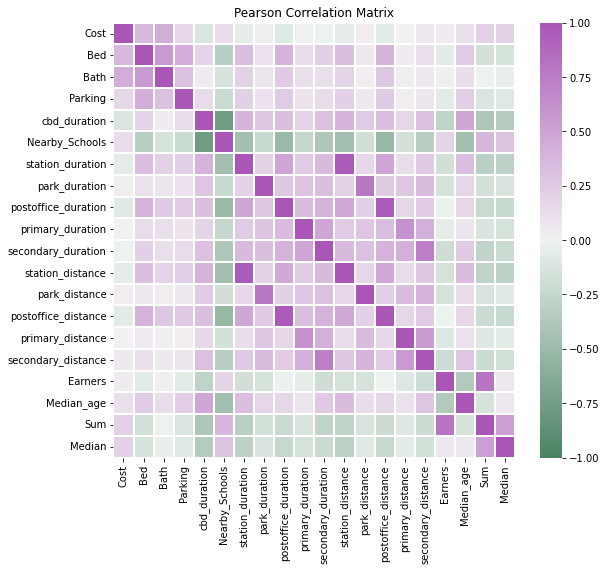

In [95]:
corrmat = properties.corr(method='pearson')
f, ax = plt.subplots(figsize =(9, 8))
colours = sns.diverging_palette(145, 300, s=60, as_cmap=True)
# possible colours: "coolwarm", "vlag"
sns.heatmap(corrmat, ax = ax, cmap=colours, linewidths = 0.1, center=0, vmin=-1)
plt.title('Pearson Correlation Matrix')
plt.savefig('../plots/correlation.jpg')
plt.show()

Find the most correlated features with rental cost of property.

In [96]:
sorted_mat = corrmat.unstack().sort_values()

# reformat series into data frame
df = pd.DataFrame(data=sorted_mat)
df.rename({0:'correlation'}, axis=1, inplace=True)
df['Index'] = df.index
df = pd.concat(
        [df.drop('Index', axis=1), 
        df['Index'].apply(pd.Series)]
    , axis=1)

# output correlation list
cost_correlations = pd.DataFrame(df[df[0] == 'Cost']['correlation'])
cost_correlations['abs_corr'] = abs(cost_correlations['correlation'])
cost_correlations.sort_values(by='abs_corr', ascending=False)

correlation  abs_corr
Cost Cost                    1.000000  1.000000
     Bath                    0.441169  0.441169
     Bed                     0.359521  0.359521
     Median                  0.209694  0.209694
     Sum                     0.209596  0.209596
     Parking                 0.164022  0.164022
     Nearby_Schools          0.132709  0.132709
     cbd_duration           -0.121661  0.121661
     Median_age              0.111141  0.111141
     postoffice_duration    -0.083672  0.083672
     postoffice_distance    -0.076687  0.076687
     station_duration       -0.051269  0.051269
     secondary_distance      0.049925  0.049925
     station_distance       -0.049167  0.049167
     Earners                 0.039102  0.039102
     park_distance           0.031907  0.031907
     park_duration           0.026537  0.026537
     primary_distance        0.014802  0.014802
     secondary_duration     -0.010871  0.010871
     primary_duration       -0.006587  0.006587

## Continuous and Categorical Data Correlations

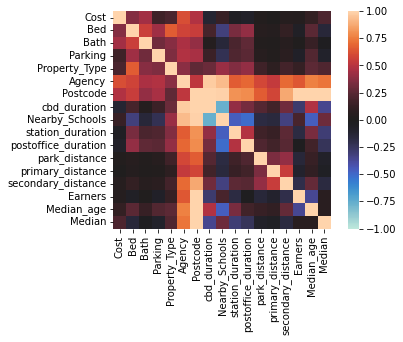

In [97]:
# get correlation of numeric attributes with cost
exclusions = ['Name', 'Coordinates', 'SA2_MAINCODE_2011', 'SA2_name', 'SA2_NAME_2011', 'SA2', 'Sum', 'postoffice_distance', 'station_distance', 'park_duration', 'secondary_duration', 'primary_duration']
corr_data = properties.drop(exclusions, axis=1)
corr_mat = dython.nominal.associations(corr_data, annot=False)

In [98]:
sorted_mat = corr_mat['corr'].unstack().sort_values()

# reformat series into data frame
df = pd.DataFrame(data=sorted_mat)
df.rename({0:'correlation'}, axis=1, inplace=True)
df['Index'] = df.index
df = pd.concat(
        [df.drop('Index', axis=1), 
        df['Index'].apply(pd.Series)]
    , axis=1)

# output correlation list
cost_correlations = pd.DataFrame(df[df[0] == 'Cost']['correlation'])
cost_correlations['abs_corr'] = abs(cost_correlations['correlation'])
cost_correlations = cost_correlations.sort_values(by='abs_corr', ascending=False)

# remove multi-level indexing
cost_correlations.index = cost_correlations.index.droplevel(0)

cost_correlations.drop('Cost')

,correlation,abs_corr
Agency,0.616671,0.616671
Postcode,0.479105,0.479105
Bath,0.441169,0.441169
Bed,0.359521,0.359521
Median,0.209694,0.209694
Property_Type,0.196008,0.196008
Parking,0.164022,0.164022
Nearby_Schools,0.132709,0.132709
cbd_duration,-0.121259,0.121259
Median_age,0.111141,0.111141


Highly correlated features to note:
- Postcode and SA2 are extremely correlated, so only include one - postcode which has slightly higher correlation with price. 
- Postcode highly correlated with income data
- cbd_duration: postcode and agency
- Median and total income - only include median
- all distance/duration combos - pick best from each category

## Categorical ANOVAs

In [109]:
# test for relationship with categorical variables using one-way ANOVA
categoricals = ['Postcode', 'Property_Type', 'Agency']

for c in categoricals:
    model = ols('Cost ~ '+c, data = properties).fit() # Oridnary least squares
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

               df        sum_sq        mean_sq         F  PR(>F)
Postcode    374.0  2.019698e+08  540026.239923  9.126862     0.0
Residual  11465.0  6.783713e+08   59168.884891       NaN     NaN
                    df        sum_sq       mean_sq         F        PR(>F)
Property_Type      9.0  3.375730e+07  3.750811e+06  52.41311  5.539890e-94
Residual       11830.0  8.465838e+08  7.156245e+04       NaN           NaN
               df        sum_sq        mean_sq         F  PR(>F)
Agency     1335.0  3.347445e+08  250744.959848  4.827422     0.0
Residual  10504.0  5.455966e+08   51941.789567       NaN     NaN


All p values are less than 0.05 so all attributes are significant.

## Feature Selection